<b>AML2019</b>

<h3>Challenge 1</h3>
<h1>House Pricing Prediction</h1>
<hr style="height:2px;border:none;color:#333;background-color:#333;"/>
<i>22<sup>th</sup> March 2019</i>

#### **Group-19**: DO Thi Duyen - LE Ta Dang Khoa

In [2]:
# Install XGBoost
!pip3 install --user 'xgboost'

    100% |################################| 114.0MB 180kB/s 
You are using pip version 18.0, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import normalize, LabelEncoder, StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from xgboost import XGBRegressor

from math import sqrt

import time

import warnings
warnings.filterwarnings("ignore")

### **1. Data Exploration**

**FIRST**, let's take an overview look at the data, as well as some statistics.

In [4]:
trainDF = pd.read_csv('challenge_data/train.csv')
trainDF.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


1. We can see many null values in **PoolQC**, **Fence** and **MiscFeature**.
2. At first, this may be a signal of unclean data, but by reading the definition of each column, it may also mean:
  - These houses don't have Pools (in the case of **PoolQC**)
  - These houses don't have Fence (in the case of **Fence**)
  - We don't have anything special to add about these houses (in the case of **MiscFeature**)

So, at quick glance, it suggests that we should spend quite sometime investigate each column of the dataset, so that pre-processing them **don't blindly discard information**.

In [5]:
trainDF.shape

(1200, 81)

In [6]:
testDF = pd.read_csv('challenge_data/test.csv')
testDF.shape

(260, 80)

In [7]:
testDF.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1201,20,RL,71.0,9353,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,Shed,0,7,2006,Oth,Abnorml
1,1202,60,RL,80.0,10400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal
2,1203,50,RM,50.0,6000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal
3,1204,20,RL,75.0,9750,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal
4,1205,20,RL,78.0,10140,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,7,2006,WD,Normal


- There are 1200 data-points in the train-set, and 260 data-points in the test-set.
- The test-set has 80 attributes while the train-set has 81, this is because the **SalePrice** column is discarded from the test-set for testing purposes.

In [8]:
trainDF.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1200.000000,1200.000000,990.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1194.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,600.500000,57.075000,70.086869,10559.411667,6.105000,5.568333,1971.350833,1984.987500,103.962312,444.886667,...,95.136667,46.016667,22.178333,3.653333,14.980833,1.909167,40.453333,6.311667,2007.810833,181414.628333
std,346.554469,42.682012,23.702029,10619.135549,1.383439,1.120138,30.048408,20.527221,183.534953,439.987844,...,124.034129,65.677629,61.507323,29.991099,54.768057,33.148327,482.323444,2.673104,1.319027,81070.908544
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1875.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,300.750000,20.000000,59.000000,7560.000000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,600.500000,50.000000,70.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,385.500000,...,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163700.000000
75%,900.250000,70.000000,80.000000,11616.000000,7.000000,6.000000,2000.000000,2004.000000,166.750000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1200.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2260.000000,...,857.000000,523.000000,552.000000,508.000000,410.000000,648.000000,15500.000000,12.000000,2010.000000,755000.000000


Looking at the overall statistics, we can see that houses' price are very polarized:
- While the _25%_, _50%_ and _75%_ are kind of close to each other, around _130k_, _160k_ and _210k_ in price, respectively;
- The _min-price_ and the _max-price_ are very far from the rest, around _40k_ and _750k_ in price.

This is pretty much expected.

**SECOND**, we'll explore the relationships between the _81 features_ of a house, beginning with **numeric attributes**.

In [9]:
# Get numeric attributes ONLY
numericTrainDF = trainDF._get_numeric_data().dropna()

# Also, drop categorical attributes that appear as numeric
numericTrainDF.drop(columns=["MSSubClass", "MoSold"], inplace=True)

Here we also remove **MSSubClass** (_the building class_) and **MoSold** (_month sold_) as they have categorical meanings, not quantitative ones, hence cannot be classified as numeric.

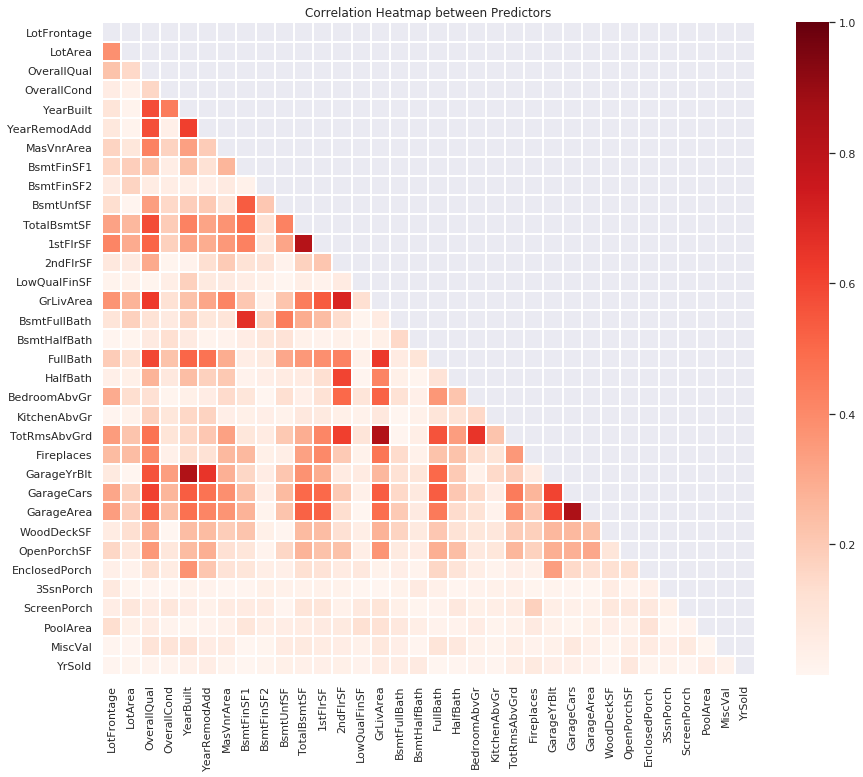

In [10]:
# Compute the ABSOLUTE correlation coefficients
# Excluding Id and SalePrice
numericCorrel = numericTrainDF.drop(columns=["Id", "SalePrice"]).corr().abs()

# Get the lower-left half of the square
mask = np.zeros_like(numericCorrel)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap
plt.figure(figsize=(15, 12))
plt.title("Correlation Heatmap between Predictors")

sns.heatmap(numericCorrel, mask=mask, cmap="Reds", square=True, linewidths=1.)

plt.show()

Here we look at the relationships bewteen **numerical predictors** only, excluding the meaningless _Id_ and the dependent variable _SalePrice_.

There are several pairs of strongly correlated variables here:
1. **1stFlrSF** (First Floor square feet) and **TotalBsmtSF** (Total square feet of basement area)
2. **TotRmsAbvGrd** (Total rooms above grade) and **GrLivArea** (Above grade (ground) living area square feet)
3. **GarageArea** (Size of garage in square feet) and **GarageCars** (Size of garage in car capacity)
4. etc.

Although there are many more pairs, for the sake of brevity, we just list 3 of the strongest ones. By refering to the definition of these predictors, we can see that the pairs are very reasonable. There seems to be no weird things that trigger us to investigate here.

However, this finding of correlated predictors is very useful in case we want to reduce the dimensions later.

Now, we'll explore the relationships between these predictors and **SalePrice**.

In [11]:
# Function to plot the horizontal heatmap (a set of variables against one)
def horizontalHeatMap(data, title=""):
    plt.figure(figsize=(25, .5))
    ax = sns.heatmap(data.T, fmt=".2f", annot=True, annot_kws={"weight":"bold"}, 
                     linewidths=1., cbar=False, cmap="Reds")

    plt.title(title)
    ax.title.set_fontsize(20)

    plt.show()

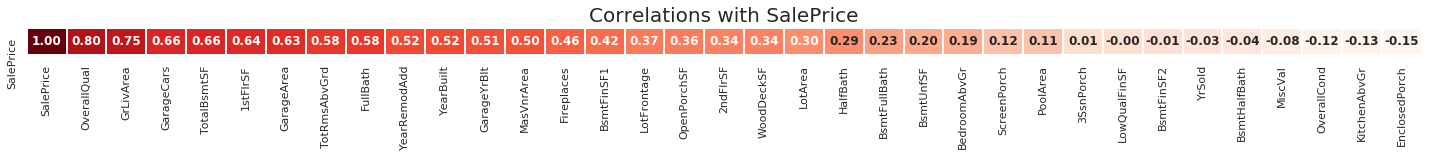

In [12]:
# Drop the meaningless column "Id", compute correlations
# Extract the "SalePrice" series, then sort descendingly
numericCorrel = numericTrainDF.drop(columns=["Id"]).corr()
sortedCorrel = numericCorrel.loc[:, ["SalePrice"]] \
                            .sort_values(by="SalePrice", ascending=False)

# Plot the heatmap
horizontalHeatMap(sortedCorrel, "Correlations with SalePrice")

First, we can see that **LowQualFinSF** (low quality finished square feet (all floors)) doesn't correlate with _SalePrice_, while **OverallQual** (overall material and finish quality) strongly correlates with _SalePrice_. This makes total sense.

Second, **GrLivArea** (above grade (ground) living area square feet), **GarageCars** (size of garage in car capacity) and **TotalBsmtSF** (total square feet of basement area) are also strongly correlated with _SalePrice_, which also make sense.

The finding of these correlated predictors will be very helpful in the case we want to reduce the dimensions, if neccessary, later.

**THIRD**, we're going explore the relationship between **non-numeric attributes** and _SalePrice_.

The method we're using is _Box Plot_, in order to sense how _Sale Prices_ are distributed within each individual category.

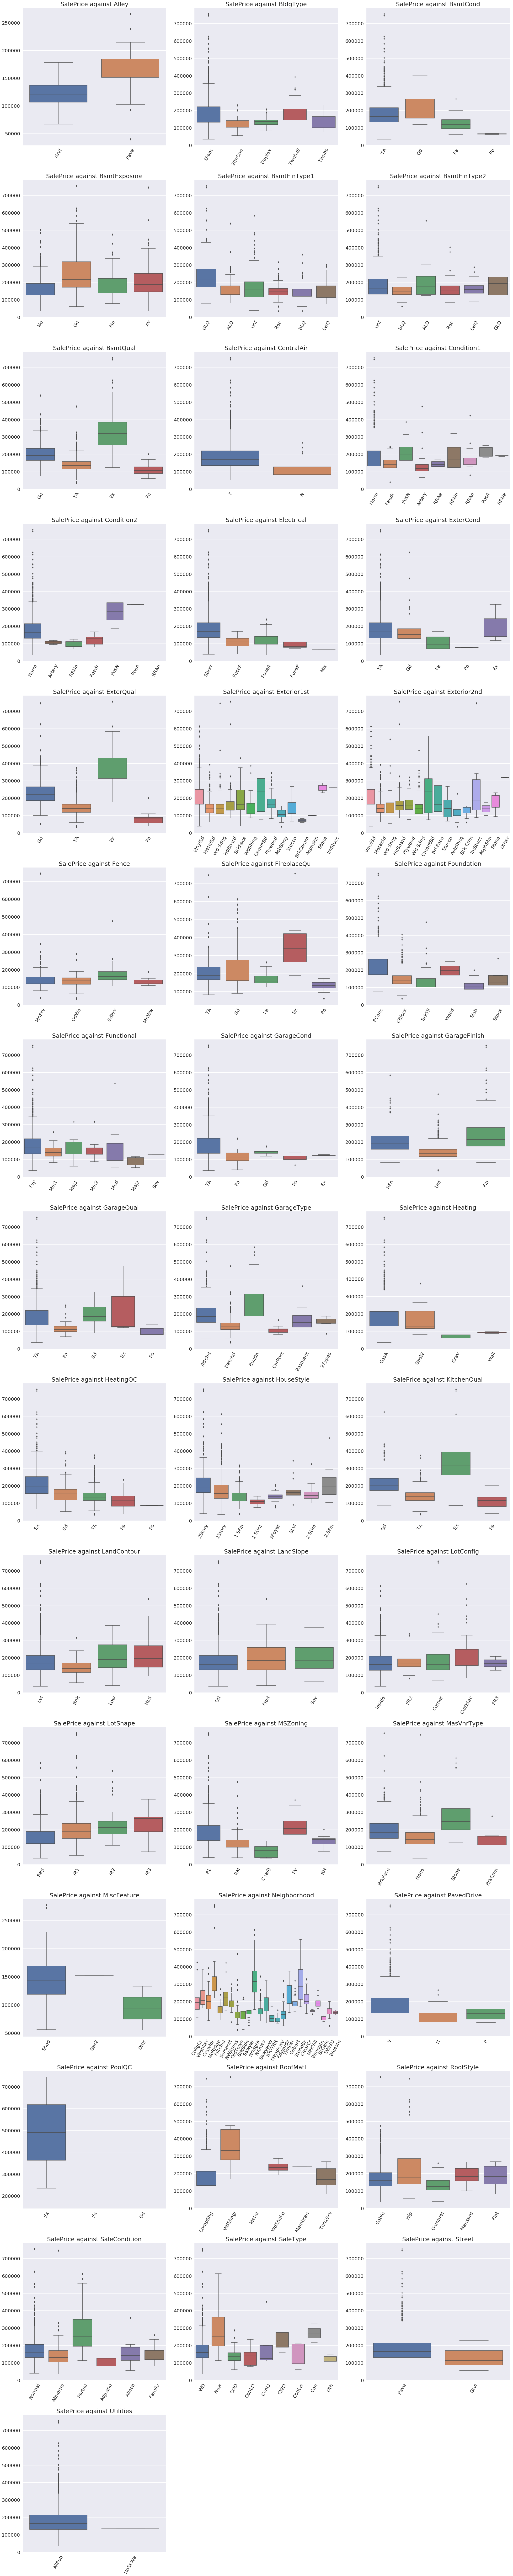

In [13]:
# Remove the meaningless "Id" attribute
dfWithoutId = trainDF.drop(['Id'], axis=1)

# Outline the Plot
fig, axes = plt.subplots(15, 3, figsize=(30, 150))

# Indexed and titled each subplot
subplot_idx = 0
predictors = list(dfWithoutId.columns)
predictors.sort()

# Plotting
for pred in predictors:
    if dfWithoutId[pred].dtype == 'object' and pred != 'SalePrice':
        # Get position and plot the subplot
        row, col = divmod(subplot_idx, 3)
        axes[row, col] = sns.boxplot(data=dfWithoutId, x=pred, y='SalePrice', 
                                     ax=axes[row, col])
        
        # Labeling each subplot
        axes[row, col].set_title('SalePrice against {}'.format(pred), fontsize=25)
        
        axes[row, col].yaxis.label.set_visible(False)
        axes[row, col].yaxis.set_tick_params(labelsize=20)
        
        axes[row, col].xaxis.label.set_visible(False)
        axes[row, col].xaxis.set_tick_params(labelsize=20)

        # Rotate the xticks
        xticks = axes[row, col].get_xticklabels()
        axes[row, col].set_xticklabels(xticks, rotation=60)
        
        # Move to next subplot
        subplot_idx += 1

# Beautify the plot
fig.delaxes(axes[14, 1])
fig.delaxes(axes[14, 2])
plt.tight_layout()

There are several strong predictors worth noted here:

1. The **Alley** predictor, leads to higher _SalePrice_ in the case of _Paved_, and lower in the case of _Grvl_.

2. The **Bsmtqual** predictor (Basement Quality), increases _SalePrice_ as its quality increases. In fact, _Ex (excellent)_ leads to highest _SalePrice_.

3. The **Neighborhood** predictor, for most values have small-margin box-plots, with the rest being medium-margin. The medium-margin box-plots are quite disinguishable in _SalePrice_ in comparison to the others (rich area). This make _Neighborhood_ quite a good predictor for _SalePrice_.

All of these make total sense, especially in the case of _Neighborhood_, since it is very often that the mere position of a house greatly detetrmine its sale value. There are many other reasonable relationships between _non-numeric predictors_ and _SalePrice_, here we only list the most interesting 3. 

Despite there aren't many strange that trigger us to investigate further, such finding allows us to reduce the dimensions (if neccessary) in later steps.

**FINALLY**, we investigate the dependence between _SalePrice_ and its _numerical predictors_. Then, we'll proceed to investigate the joint distribution between _SalesPrice_ and the predictors it's most dependent on. The goal is to get a sense of the distribution underlying our data, which is neccessary if we want to employ **Gaussian Processes** later.

For this purpose, we employ **Mutual Information**, which measures general dependence between two random variables, instead of **Correlation**, which only measures linear dependence bewteen them. The higher the _mutual information_ between _SalesPrice_ and one of its predictor, the more we can determine a sale-price using the values of that predictor.

In [14]:
from sklearn.feature_selection import mutual_info_regression

# Get Numeric Predictors
numericPredictors = numericTrainDF.drop(columns=["Id", "SalePrice"])

# Get Mutual Information between SalePrice and each predictor
# Then turn it into a DataFrame, and sort descendingly
numericMI = mutual_info_regression(numericPredictors, numericTrainDF['SalePrice'])

numericMIDF = pd.DataFrame(data=numericMI, index=numericPredictors.columns, columns=['MI'])
numericMIDF.sort_values(by='MI', inplace=True, ascending=False)

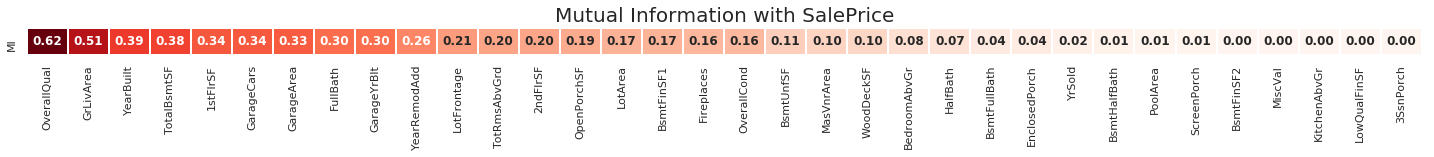

In [15]:
# Plot the heatmap
horizontalHeatMap(numericMIDF, "Mutual Information with SalePrice")

Here we have:
- **OverallQual** (Lot size in square feet), 
- **GrLivArea** (Above grade (ground) living area square feet), 

provides the most valuable information in dertemining the SalePrice of a house. This kind of make sense because in practice, these two are vital factors house-buyers take into account before spending their money.

In [16]:
# Function to plot the joint-distribution
def plot_salesprice_jointpdf_with(predictor):
    sns.jointplot(x=numericTrainDF['SalePrice'], y=numericTrainDF[predictor],
                  kind='kde', color='red')
    
    plt.show()

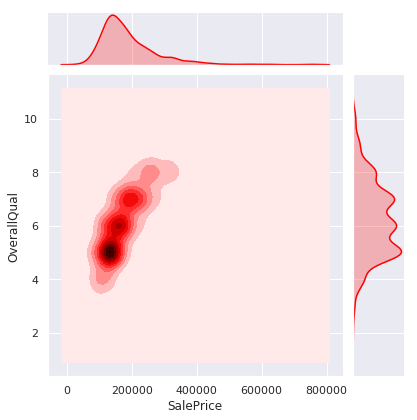

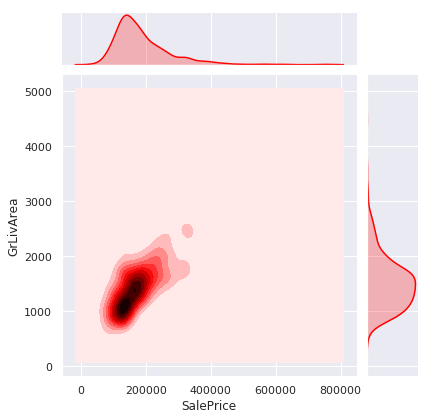

In [17]:
for pred in ['OverallQual', 'GrLivArea']:
    plot_salesprice_jointpdf_with(pred)

**REMARK**. Do these justfy our future usage of _Gaussian process_. We would, although reluctantly, say **Yes**.

- Recalling the fact that _Gaussian Process_ finds (in a Bayesian way) a distribution over all possible function f, where each f is represented by a valued-vector. What _Gaussian Process_ assumes is the **normality** of that distribution.

- In other words, the dsitribution of all possible _f_, given a specific value of the input-vector, is assumed to be normal.

- In practice, the input-vector is very large, so people only take the most "informing" variables, here we have **OverallQual** and **GrLivArea**, and verify each normality against the dependent-variable, that is _SalePrice_

- Although _SalePrice_ looks a little bit skewed, it is somewhat normal, therefore, its joint dsitribution with _GrLivArea_, which is normally distributed, does satisfy this assumption.

- However, the joint distribution with _OverallQual_ is not normal. This is because _OverallQual_ is more categorical than continuous, leads to the issue of having multiple values in the "middle". But if we "bin" the data in the sense that these different middle values all represent _medium overall-quality_, then we will have kind of a normal distribution.

In conclusion, this situation is very similar to the _linearity-check_ we do in traditional linear regression, where the relationship is loosely linear and our models still work very well. The joint-distributions we're seeing now are normal to some extend, enabling the result we get from _Gaussian Process_ to be reliable.

---

### **2. Data Preprocessing**

#### **a. Data pre-processing: Missing data**

**FIRST**, we will handle missing values on both training set and testing set since many models do not work when these values are in the dataset. Importantly, the missing values also affect on performance of learning algorithms.

We defined a function ```check_missing``` to summary the missing values of each column in these datasets and a function ```fill_missing``` to handle it. 

In [2]:
# Function to summary the missing values on a given dataset
def check_missing(df):
    """ Summary missing values on a given dataset
    
    Parameters:
        df (DataFrame): a dataset to check
    
    Return:
        summary_df (DataFrame): the summary dataframe of missing values
    """
    
    missing_df = pd.DataFrame(train_data.isnull().sum())\
                    .reset_index().rename({'index':'column', 0:'count'}, axis=1)
    df = missing_df[missing_df['count']>0]
    df['percentage'] = df['count'].divide(train_data.shape[0]).round(decimals=3)
    return df

# Function to fill missing values
def fill_missing(list_df, cols_vals):
    """Fill missing values on a given dataset
    
    Parameters:
        list_df (list of DataFrame): A list of dataframes to fill
        cols_vals (list of Tuple): A list of tuples, each tuple contains a column name and a value to fill
    
    Return:
        list_df (list of DataFrame): A list of dataframes which are filled missing values.
    """
    for df in list_df:
        for tup in cols_vals:
            df.update(df[tup[0]].fillna(tup[1]))
    return list_df

**NEXT**, we load the data and see its summarization to decide what to do next in handling the missing data.

In [3]:
# Load training set and display problems
train_data = pd.read_csv('challenge_data/train.csv')

print("\n\nMissing values on train data:")
display(check_missing(train_data))

# ==========================================
# TODO: Move this part to the bottom section
# Load test-data
test_data = pd.read_csv('challenge_data/test.csv')



Missing values on train data:


,column,count,percentage
3,LotFrontage,210,0.175
6,Alley,1125,0.938
25,MasVnrType,6,0.005
26,MasVnrArea,6,0.005
30,BsmtQual,32,0.027
31,BsmtCond,32,0.027
32,BsmtExposure,33,0.028
33,BsmtFinType1,32,0.027
35,BsmtFinType2,33,0.028
57,FireplaceQu,564,0.470


In [4]:
# Based on the description of the dataset, these features are grouped together by its types.
# The categorical features which have missing values not randomly
valNone_cat = ['Alley', 'MasVnrType',\
               'BsmtQual','BsmtCond', 'BsmtExposure','BsmtFinType1','BsmtFinType2',\
               'FireplaceQu',\
               'GarageArea','GarageType','GarageFinish','GarageQual','GarageCond',
               'PoolQC', 'Fence', 'Electrical']

# The numerical features which have missing values not randomly
valNone_0 = ['MasVnrArea','LotFrontage']

# Fill in missing values
[train_data_nomissing] = fill_missing(
                                      [train_data], 
                                      [(valNone_cat, 'Have-None'), (valNone_0, 0), 
                                       ('GarageYrBlt', train_data['GarageYrBlt'].mode()[0])]
                                     )

# ==========================================
# TODO: Move this part to the bottom section
# Filling missing values for test-data
[test_data_nomissing] = fill_missing(
                                     [test_data], 
                                     [(valNone_cat, 'Have-None'), (valNone_0, 0), 
                                       ('GarageYrBlt', train_data['GarageYrBlt'].mode()[0])]
                                     )

**COMMENT.**

We handle the missing values depending on its case. 
* We ignore the features which have too many missing values (**99.70%**) and unknown missing's reason, for example: _MiscFeature_.
* For the features which we know the reason of missing, we correct it. For example, we filled the value _Have-None_ or _0_ to features _Alley_, _BsmtQual_, _GarageArea_, _PoolQC_, _MasVnrArea_, _LotFrontage_, etc. because it means that the house has no these facilities. 
* For the features which we do not know reasons of missing like _GarageYrBlt_, we fill it with mode for categorical variables and mean for numerical variables.

_How to know the reasons of missing?_ We may find out it on some ways like reading carefully the description of the dataset, or in cases we do not have a description in detail, we can make inferences from the summary of missing values and the meaning of the variables. As can be seen from the summary, there are some features which have the same number of missing values. These features belong to some groups like basement, garage. Definitely, it is no coincidence.

#### **b. Data pre-processing: Split features-target, convert data types**

In [5]:
# Function to get features and target
def get_X_y(df, X_excluded=[], y_included=[]):
    """Get features (X) and target (y) of a given dataframe
    
    Parameters:
        df (DataFrame): A dataframe
        X_excluded (str): Column names which do not belong to X
        y_included (str): Column names of targets.
    
    Return:
        X, y (DataFrame)
    """
    return df.drop(X_excluded+y_included, axis=1), df[y_included]

# Function to get numerical variables
def get_numeric_dataframe(list_df):
    """Get numerical variables of a given list dataframe.
    
    Parameters:
        list_df (list of DataFrame): A list of dataframes
    
    Return:
        List of numerical variables respectively list of given dataframes.
    """
    return [df.select_dtypes(exclude=['object']) for df in list_df]

# Function to get categorical variables
def get_categorical_dataframe(list_df):
    """Get categorical variables of a given list dataframe.
    
    Parameters:
        list_df (list of DataFrame): A list of dataframes
    
    Return:
        List of categorical variables respectively list of given dataframes.
    """
    return [df.select_dtypes(include=['object']) for df in list_df]

In [6]:
# Get X (features) and y (target)
X_train, y_train = get_X_y(train_data_nomissing, ['Id','MiscFeature'],['SalePrice'])

# Split X (features) into numerical & categorical
[X_train_num] = get_numeric_dataframe([X_train])
[X_train_cat] = get_categorical_dataframe([X_train])

# ==========================================
# TODO: Move this part to the bottom section
# Test-set: Split X (features) into numerical & categorical
X_test, _ = get_X_y(test_data_nomissing, ['Id', 'MiscFeature'])

[X_test_num] = get_numeric_dataframe([X_test])
[X_test_cat] = get_categorical_dataframe([X_test])

**COMMENT**. Here we simply split the dataset into 2 parts, vertically:
- One set with numerical attributes only, and another set with categorical attributes only. 
- We did this because we want to handle these 2 types of data separately before re-joining them.

#### **c. Data pre-processing: Categorical encoding**

In [7]:
from collections import defaultdict

# APPROACH 1: Convert categorical variables to numerical variables 
# using LabelEncoder
d = defaultdict(LabelEncoder)

# ==============================================
# TODO: Seperate the process into train and test
# TODO: Move test to the bottom-section
X_cat = pd.concat([X_train_cat, X_test_cat], ignore_index=True)
fit = X_cat.apply(lambda x: d[x.name].fit_transform(x))

X_train_cat_encoded = X_train_cat.apply(lambda x: d[x.name].transform(x))
X_test_cat_encoded = X_test_cat.apply(lambda x: d[x.name].transform(x))

In [8]:
# APPROACH 2: Convert categorical variables to numerical variables 
# using DUMMY VARIABLES
X_train_cat_dummied = pd.get_dummies(X_train_cat, columns=X_train_cat.columns,
                                     drop_first=True)

**REMARK 1**. 

Because several models work only on numerical data, we need to encode categorical variables into numerical variables. There are two common ways: encode labels with value between 0 and n_classes-1 or encode labels as dummy variables. In this project, we use both.

1. We use _LabelEncoder_ for several models such as XGBoost, Random Forests,... since in some experiences, _LabelEncoder_ yield better modeling performance than the _dummy variables_ conversion.

2. We use _dummy variables_ in _Gaussian Process_ for several reasons, one of them is about _implicit meanings_. That is, categorical variables often does not imply ordering or numerical difference, but if we convert them into numbers, _Gaussian Process_ will wrongly take these implicit-orderings and implicit-difference into account, leads to bad models.

**REMARK 2**.

Since we approach the problem of numericalising categorical-data in 2 different ways, from now on, we seperate the pre-processing process into 2 separate pipelines:

1. **Pipeline 1**: This is used for _ElasticNet_ and _XGBoost_:
   - _Full standardization_ of both numerical and label-encoded data 
   - _Not remove outliers_ as these methods are less sensitive to outliers
   - _Feature selection_ with _RFECV_, which selects features using cross-validation. We used this method simply for comparison purposes, to compare it with traditional methods such as _Mutual Information_ or _F-test_.
   
2. **Pipeline 2**: This is used for _Gaussian Process_:
   - _Partial standardization_ applies only on _numerical data_. We do not apply _StandardScaler_ to _dummy variables_ because their values are only 0 and 1, already on the same scale with scaled numerical features. Also, scaling dummy variables is often advised against in practice.
   - _Remove outliers_ as the _Bayesian-update step_ of _Gaussian Process_ are very sensitive to outliers.
   - _Feature_ selection is done in combination with model-tuning (that is, _Gaussian process regressor_), using cross-validation to pick either _Mutual Information_ or _F-test_, and the best value for _K_ in _SelectKBest()_. We chose this method simply for comparing with _RFECV_.
   - Since we use _feature selection in combination with model-tuning_, the code for this step will be put in the next section.

**REMARK 3**. Why _Standardizing_?

1. First, for data that has different scales, it is necessary that we re-scale the data so that no feature outweights the others just by having a larger scale.

2. We chose _Standardization_ instead of _Normalization_ for several reasons:
   - _Standardization_, unlike _Normalization_, doesn't bounded our data to any range, this is great for regression tasks.
   - _Standardization_ is less sensitive to outliers than _Normalization_, and this is very important in our house-prices dataset, since prices are set individually and hence often include a lot of outliers.
   
3. Another reason: The _MinMaxScaler_ we use to normalize our **train-dataset** will be applied on the **test-dataset** before predicting, and this will, very likely, produce a value that are less than 0 or greater than 1 (if some values in test are greater than the _max. of train_, or less than the _min. of train_). This is undesirable.

---
#### **D1. Pipeline 1: Full Standardization + RFECV**

In [9]:
# Merge categorical variables and numerical variables
X_train_merged = pd.concat([X_train_num, X_train_cat_encoded], axis=1)

# FULL STANDARDIZATION:
full_standardizer_X = StandardScaler().fit(X_train_merged)
X_train_fullscaled = pd.DataFrame(full_standardizer_X.transform(X_train_merged), 
                                  columns=X_train_merged.columns)

# =============================================
# TODO: Moving to the bottom (for the test-set)
# Change columns to ???

# Splitting into predictors and targets (test-set)
X_test_merge = pd.concat([X_test_num, X_test_cat_encoded], axis=1)

# FULL STANDARDIZATION (test-set):
X_test_fullscaled = pd.DataFrame(full_standardizer_X.transform(X_test_merge), 
                                 columns=X_test_merge.columns)

##### **FEATURE SELECTION with RFECV**
On a dataset, each feature affects different ways to the target. Some of them are really helpful while the other may be useless, consuming resources or even harmful to models. Here we use _RFECV_ method which is recursive feature elimination and cross-validated selection of the best number of features to see how the number of features used in a model affect to its performance.

**FIRST**, since our metric is the RMSE between the **logarithm of predicted** and **logarithm of observed**, we create a helper function that computes this metric. This serves as a base for our cross-validation in _RFECV_

In [10]:
# The RMSE between the log of the predicted and the log of the observed
def rmse_log(actual, pred):
    """Return the RMSE between the logarithm of predicted and logarithm of observed
    
    Parameters:
        actual (Series-like): The observed values
        pred (Series-like): The predicted values
    
    Return:
        The RMSE between the logarithm of predicted and logarithm of observed
    """
    return sqrt(mean_squared_error(np.log(actual), np.log(pred)))

**SECOND**, we use _RandomForestRegressor_ as an estimator and _RFECV_ as the feature selection technique to select the optimal number of features used in models.

Optimal number of features : 24


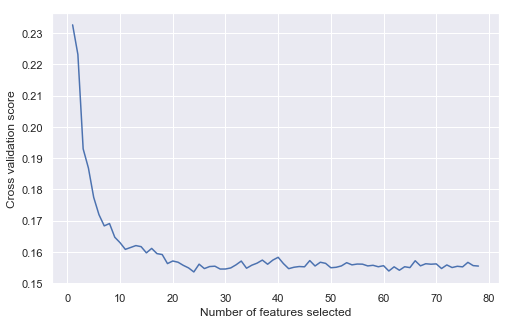

In [11]:
# Create an estimator
estimator = RandomForestRegressor(random_state=42)

# Feature selection using recursive feature elimination and cross-validated selection
selector = RFECV(estimator, step=1, cv=5, scoring=make_scorer(rmse_log, greater_is_better=False))
selector = selector.fit(X_train_fullscaled, y_train)

print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(8,5))
plt.plot(range(1, len(selector.grid_scores_) + 1), -selector.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.show()

# Select the optimal features
selected_features = [feature for (boolean, feature) in zip(selector.support_, X_train_fullscaled.columns) if boolean]
X_train_rmfeatures = X_train_fullscaled[selected_features]

# =====================================
# TODO: Move this to the bottom section
X_test_rmfeatures = X_test_fullscaled[selected_features]

**COMMENT**

1. Since the datasets is not big, it does not matter when we use all of its features for modeling. We would like to observe how the performance of the model descrease to keep the best one. Therefore we use _RFECV_ here.

2. We use _RandomForestRegressor_ as an estimator because it randomly selects observations and features to built the model. When using RFECV, we want to eliminate features randomly.

3. The plot shows that it is better to use more than 10 features in the model. Over 10 features, the performance of the model fluctuate on small ranges. Because each model has its own ways to learning, the optimal number of features in this model may not be the optimal on others. However, it gives us an intuition for model selection and tunning hyper-parameter.

---
#### **D2. Pipeline 2: Partial (numerical) Standardization + Remove outliers**

In [12]:
# PARTIAL (numerical) STANDARDISATION
numerical_standardizer_X = StandardScaler().fit(X_train_num)
X_train_numscaled = pd.DataFrame(numerical_standardizer_X.transform(X_train_num), 
                                 columns=X_train_num.columns)

In [13]:
# Remove outliers, data-points that are more than 3.5 standard-devation from the mean
X_train_rmOutliers = X_train_numscaled[X_train_numscaled\
                                           .apply(lambda x: np.abs(x - x.mean()) / x.std() < 3.5)\
                                           .all(axis=1)]
X_train_rmOutliers.shape

(914, 36)

In [14]:
train_merged = pd.concat([X_train_rmOutliers, X_train_cat_dummied, y_train], join='inner', axis=1)
[X_train_dummied, y_train_dummied] = get_X_y(train_merged, y_included=['SalePrice'])

**COMMENT**. Here we did several things

1. Apply _partial standardization_ to numerical attributes of X_train
2. Base on that _partial standardization_, eliminate all outliers, data-points that are **more than 3.5 std away from the mean**.
3. Finally, we join the _numerical attributes_, the _dummied attributes_ to form an X_train with dummy variables

---

### **3+4. Model Selection & Parameter Optimisation**

**FIRST REMARK for this section**.

1. Here we build 2 data-preparation pipelines using only the train-dataset, and don't look at the test-dataset. This is recommended because the test set won't be seen in practice.

2. For this, we will:
   - Use **X_train_rmfeatures** and **y_train** for training with _ElasticNet_ and _XGBRegressor_.
   - Use **X_train_dummied** and **y_train_dummied** for training with _GaussianProcessRegressor_.

#### **1. Use Cross-validation to evaluate several models on standardized data**.
 
We tried several popular models for regression tasks such as RandomForestRegressor, ElasticNetCV, XGBRegressor, which are rosbust to the presence of outliers.

We also evaluate on two different datasets:
* Training set with 78-preprocessed features
* Training set with 24 features selected by Random Forests estimator.

#### **a. Model selection**.

In [15]:
# Helper function to get the cross-validation results on a well-formed dataframe.
def get_cv_result(cv, model):
    """Get the cross-validation results on a well-formed datafram
    
    Parameters:
        cv (Dictionary): The return of cross-validation
        model: The model which is used for cross-validation
    
    Returns:
        avg (DataFrame): The result dataframe of cross-validation
    """
    avg = {}
    for k,vals in cv.items():
        avg[k] = np.around(np.mean(vals), 4)
    avg['model'] = model
    avg['test_score'] = - avg['test_score']
    avg['train_score'] = - avg['train_score']
    return avg

# This function is used to implemente cross-validation to evaluate performance of models
def model_selection(models, X, y, cv=5, scoring=make_scorer(rmse_log, greater_is_better=False)):
    """Evaluate models using cross-validation
    
    Parameters:
        models: A list of models
        X (DataFrame): Feature set of the given data
        y (DataFrame): Target set of the given data
        scoring: The scoring function used to evaluate models
    
    Returns:
        DataFrame of cross-validation of models
    """
    cv_results = []
    for model in models:
        cv_result = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
        cv_results.append(get_cv_result(cv_result, model))
    return pd.DataFrame(cv_results)[['model', 'fit_time', 'score_time', 'test_score', 'train_score']].sort_values(by=['test_score'])

In [37]:
# Models
random_forests = RandomForestRegressor()
elasticNet = ElasticNetCV(random_state=0)
xgb = XGBRegressor(seed=42)

models = [random_forests, elasticNet, xgb]

# Models using training set with 78-preprocessed-features
print("\nCross-validation on training set with 78-preprocessed features")
models_78f = model_selection(models, X=X_train_fullscaled, y=y_train)
display(models_78f)

# Models using training set with 24-selected features
print("\n\nCross-validation on training set with 24-selected features")
models_24f = model_selection(models, X=X_train_rmfeatures, y=y_train)
display(models_24f)


Cross-validation on training set with 78-preprocessed features


,model,fit_time,score_time,test_score,train_score
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.5894,0.0078,0.1340,0.0856
0,"RandomForestRegressor(bootstrap=True, criterio...",0.2220,0.0014,0.1529,0.0695
1,"ElasticNetCV(alphas=None, copy_X=True, cv=None...",0.1200,0.0010,0.3641,0.3642




Cross-validation on training set with 24-selected features


,model,fit_time,score_time,test_score,train_score
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.2529,0.0043,0.1385,0.0943
0,"RandomForestRegressor(bootstrap=True, criterio...",0.1339,0.0004,0.1549,0.0730
1,"ElasticNetCV(alphas=None, copy_X=True, cv=None...",0.0958,0.0006,0.3779,0.3784


**COMMENT.**

1. **Performance**:

    - Between the models: 
    <p>The outputs show that <b>XGBRegressor outperforms</b> <i>RandomForestRegressor</i> and <i>ElasticNet</i> on both datasets. Its test_score using cross-validation is <b>~0.13</b> while the others are ~0.15 and ~0.24. Therefore, we will use the best model, <i>XGBRegressor</i>, for tunning parameters in next part.</p>
    
    - Between sub-set and full-set:
        <p>Using fewer features than the full set but bigger than 10 (24/78 features), the performance of <i>XGBRegressor</i> just slightly descreases while the performance of ElasticNetCV almost remains. It can be explained through the graph on section <i>2. f. Feature selection</i>.</p>
        <p>Only <i>RandomForestRegressor</i> has the better result on the selected-feature set than on the full set. It becauses these features are chosen by itsefl, <i>RandomForestRegressor</i> estimator.</p>

2. **Model Complexity & Interpretability**
    - _XGBoost_: Its complexity is **O(Kd ∥x∥<sub>0</sub> log<sub>n</sub>)**, where K is the number of trees, d is a maximum depth per tree, and ∥x∥<sub>o</sub> is number of "non-missing entries in the training data". _XGBoost model_ is a linear combination of decision trees, therefore, we can interpret xgboost model by interpreting individual trees.
    - _Random Forest_: Its complexity for building a complete unpruned decision tree is **O( v * n log(n) )**, where _n_ is the number of records and _v_ is the number of variables/attributes. But we often restrict the number of trees _ntree_, the number of variables to sample at each node _mtry_, the depth of the trees the maximum depth of the tree _d_, then the complexity is: **O( ntree \* mtry \* d \* n)**. Random forest models are not all that interpretable; they are like black boxes since they combines many ensemble models.
    - _ElasticsNet_: Its complexity is **O(ALSK<sup>2</sup>n)**  where A is the grid size of the tuning parameter α that balances the weights of ridge versus LASSO, K is number of candidate features, S is the computational load increases linearly in the number of data splits used in cross-validation, L is the number of points in grid. Elastic Net is interpretable since it produces a regression model that is penalized with both the L1-norm and L2-norm from Ridge and Lasso.
4. **Handling different data types**
    - We think _XGBoost_, _Random Forest_, _ElasticsNet_ are a very powerful model that can handle various data types, as long as we convert it to the appropriate numerical vectors (and maybe categorical variables when use packages in R).
    - However, for data of images and videos, we don't think it works as good as _Deep Neural Nets_ for many reasons. One of them lies in the difficulty of choosing kernels. Kernel is the key of modeling with _Gaussian Process_, as it encodes some **prior knowledge of similarity measures** about our dataset. This is very hard to do in the case of images/videos, since grasping similarity measures about the raw pixels is quite conuter-intuitive.
5. **Does the model return uncertainty estimates along with predictions?**
    Prediction Interval tends to be underutilized for tree-based methods like _XGBoost_, _Random Forest_

#### **b. Tunning parameters of the best model**.

In [36]:
scoring=make_scorer(rmse_log, greater_is_better=False)
xgb_tunned = XGBRegressor(colsample_bytree=0.4,
                             gamma=0,                 
                             learning_rate=0.07,
                             max_depth=3,
                             min_child_weight=1.5,
                             n_estimators=1000,                                                                    
                             reg_alpha=0.75,
                             reg_lambda=0.45,
                             subsample=0.6,
                             seed=42) 

# Models using data train with 78-preprocessed features
tunned_model = model_selection([xgb_tunned], X=X_train_fullscaled, y=y_train)
display(tunned_model)

,model,fit_time,score_time,test_score,train_score
0,"XGBRegressor(base_score=0.5, booster='gbtree',...",3.7646,0.0147,0.1276,0.0267


#### **2. Tuning Gaussian Process with a Pipeline**

In [11]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal

# Using mutual_info_regression for feature-selection
mutual_info_selector = SelectKBest(score_func=mutual_info_regression)

# Choosing Matern-kernel with nu=0.5 for least smoothness
# and low computational-cost
matern_kernel = 1.0**2 * Matern(nu=0.5)
gaussian_regressor = GaussianProcessRegressor(kernel=matern_kernel, random_state=307)

# The combined Pipeline
gaussian_pipeline = Pipeline([
    ("feature_selector", mutual_info_selector),
    ("regressor", gaussian_regressor)
])

# Distribution of Hyper-parametrs
features_nb = X_train_dummied.shape[1]
params_distribution = {
    'feature_selector__k': range(features_nb//2, features_nb*3//4),
    'regressor__alpha': reciprocal(1e-6, 0.1)
}

**COMMENT**. Here we did several things:

1. First, instead of doing _feature-selection_ seperately, we treated it as part of a **Pipeline** that needs to be tuned, for the following reasons:
   - How do we know how many features to keep? If we _feature-selecting_ separately, the _derived number of kept features_ is only best when goes with a _barebone, un-tuned_ model.
   - But if we put it in a Pipeline and tune, the derived number will be best in a combined manner (both _feature-selection_ and _model-tuning_).
   
2. Second, why **mutual_info_regression**? Why that strange **Matern kernel**?
   - First, this code is reduced for the sake of brevity. In reality, we spent hours of _try-and-err_ to know what should be used.
   - Second, since this is a **design-choice** that has no _solution-space_ to search upfront, we had to do this by hand (with some prior).
   - Third, as we repeated the tuning process many times (_try-and-err_), to save time and to avoid overfitting, we only use 30% of the data-points. Only after reaching a safe design choice will we settle and Cross-validate on the whole dataset.
   - For further discussion on those _design-choices_, please read the next remark section.

**REMARK 1**. On choosing **mutual_info_regression** metric, and the **(50%, 75%)-range** for K in _SelectKBest()_.

1. First, our prior is that while _f_regression_ only captures linear dependency, _mutual-info-regression_ can capture any kind of dependency. Together with the fact that our data doesn't seem that linear, we only tried with _f_regression_ for several times.

2. Second, after seeing that _f_regression_ did give worse results, most of our time were spent on picking the _right-range-for-K_ using _mutual-info-regression_. The _50% to 75%_ range is just a heuristic after many try-and-err in which our prior was:
   - not to include too much variables, to avoid overfitting
   - not to use too few variables, as it reduces the model's power

We did try, for a few times, both the _lower range_ and the _higher range_ to see if the results confirmed our prior. After that, we focus on picking the best middle-range and _(50%, 75%)_ came (within our limited time).

**REMARK 2**. On choosing **Matern Kernel** metric, and the **reciprocal-distribution** for _alpha_ in _GaussianProcessRegressor_.

1. First, the choice for _reciprocal-distribution_ is quite reasonable:
   - Recall the fact that _alpha_ controls the _noise-level_ added to the _covariance-matrix_ that determines our _Gaussian Process_, a high alpha will encode a prior that thinks the data are very noisy around the conditional expected values, 
   - Although this is quite true to our dataset, our dataset is not too noisy that we need a very high alpha. But what is the optimal scale? _0.1_, _0.01_, or _0.00001_, etc.?
   - Since we don't know that, we want _alpha_ to have the same chance of being drawn **regardless of scale**:
   - **from** _1e-6_ (considered as normal in comparison to the default-value of _1e-10_); **to** _0.1_ (considered as very high in comparison to the default-value of _1e-10_)
   - That's why we use **reciprocal** instead of **uniform**, on that specific range.

2. Second, the strange _Matern kernel_ we used is based on two priors:
   - First, we can do certain operations on a kernel to produce another kernel.
   - The default kernel is _RBF_, but it assumes our data is very **smooth**, which isn't true as our data is quite noisy. So we used a more general kernel, **Matern**, in which the _nu-parameter_ controls its smoothness (_nu = inf_ and we have the _RBF kernel_).
   - According to the scikit-learn API, computation is costly when _nu-parameter_ lies outside [0.5, 1.5, 2.5, 'inf'], we picked the smallest value of 0.5.
   - After several try-and-error, that strange **Matern** is what we get as kernel.

In [12]:
from sklearn.metrics.scorer import make_scorer

gaussian_random_cv = RandomizedSearchCV(gaussian_pipeline, params_distribution, 
                                        scoring=make_scorer(rmse_log, greater_is_better=False),
                                        cv=4, n_iter=60, verbose=2)

**COMMENT**. Here we run a _Randomized Search_ with 60 turns of _4-fold CV_ to select the best model:

1. Why _RandomizedSearch_? Why 60 turns?
 - First, _RandomizedSearch_ enables us to control our computational budget, we set the number of turns and it runs in exactly that.
 - Second, it is not hard to prove that in just 60 iterations, _RandomizedSearch_ can guarantee us a **5% within the true optimal** in **95% of the time**. On the other hand, _GridSearch_ doesn't guarantee us anything.
 
2. We also passed in our custom-build metric **rmse_log**. Please notice that this is a less-is-better metric and therefore _scikit-learn_ will output a negative score. Take its absolute value and we'll be OK.

In [13]:
gaussian_random_cv.fit(X_train_dummied, y_train_dummied)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] feature_selector__k=159, regressor__alpha=0.0020748695113633154 .
[CV]  feature_selector__k=159, regressor__alpha=0.0020748695113633154, total=  10.8s
[CV] feature_selector__k=159, regressor__alpha=0.0020748695113633154 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[CV]  feature_selector__k=159, regressor__alpha=0.0020748695113633154, total=  10.0s
[CV] feature_selector__k=159, regressor__alpha=0.0020748695113633154 .
[CV]  feature_selector__k=159, regressor__alpha=0.0020748695113633154, total=  10.2s
[CV] feature_selector__k=159, regressor__alpha=0.0020748695113633154 .
[CV]  feature_selector__k=159, regressor__alpha=0.0020748695113633154, total=   9.9s
[CV] feature_selector__k=179, regressor__alpha=0.0007645565432390236 .
[CV]  feature_selector__k=179, regressor__alpha=0.0007645565432390236, total=  12.4s
[CV] feature_selector__k=179, regressor__alpha=0.0007645565432390236 .
[CV]  feature_selector__k=179, regressor__alpha=0.0007645565432390236, total=   9.7s
[CV] feature_selector__k=179, regressor__alpha=0.0007645565432390236 .
[CV]  feature_selector__k=179, regressor__alpha=0.0007645565432390236, total=  13.2s
[CV] feature_selector__k=179, regressor__alpha=0.0007645565432390236 .
[CV]  feature_selector__k=179, regressor__alpha=0.00076455654323

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 49.5min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('feature_selector', SelectKBest(k=10,
      score_func=<function mutual_info_regression at 0x0000020735918378>)), ('regressor', GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=1, nu=0.5),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=307))]),
          fit_params=None, iid=True, n_iter=60, n_jobs=1,
          param_distributions={'feature_selector__k': range(124, 186), 'regressor__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020736E21A20>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn',
          scoring=make_scorer(rmse_log, greater_is_better=False),
          verbose=2)

In [14]:
# Negate the accuracy-output because sciki-learn defaults
# less-is-better metrics to be negative so that
# it can consistently maximising
print("RMSE-Log Error: {}".format(-gaussian_random_cv.best_score_))

# Output the tuned hyper-parameters
print("Tuned number-of-features: {}".format(gaussian_random_cv\
                                            .best_params_['feature_selector__k']))
print("Tuned gaussian-regressor-alpha: {}".format(gaussian_random_cv\
                                                  .best_params_['regressor__alpha']))

RMSE-Log Error: 0.10794413896650071
Tuned number-of-features: 146
Tuned gaussian-regressor-alpha: 0.0010722567516387965


**COMMENT & REMARKS**.

1. First, the result of **0.11** is quite good for a single-estimator in this task. We believe that given more time, this performance can be improved by:
  - Read more about **Gaussian Process** to understand different kernels and their assumptions
  - Conduct deeper-investigation on our data to select features consciously, not automatically as current.
  
2. The optimal hyper-parameters of:
  - _177 features_ reasonates quite well with our prior on picking a good range for K, it lies slightly in the top-middle of the range,  
  - _alpha = 0.006_ is quite high in comparison to the default value of _1e-10_, and is quite low in comparison to the very high value of _0.1_. This also reasonates well with our prior.
  
3. **Model Complexity & Interpretability**
   - The complexity of _Gaussian Process_ is **O(n^3)**, as its most expensive operation is _matrix-inverse_.
   - On interpretability, while the prediction of _Gaussian Process_ is very easy to interprete (it's a probability distribution); the whole model is a multivariate normal distribution represented by its mean and covariance-matrix. Although it's not hard to intepret as in the case of _Deep Neural Nets_ or _SVM_, it's still quite interpretable, just not at the level of _Decision Tree_ or _Linear Regression_.

4. **Handling different data types**:
   - We think _Gaussian Process_ is a very powerful model that can handle various data types, as long as we convert it to the appropriate numerical vectors.
   - However, for data of images and videos, we don't think it works as good as _Deep Neural Nets_ for many reasons. One of them lies in the difficulty of choosing kernels. Kernel is the key of modeling with _Gaussian Process_, as it encodes some **prior knowledge of similarity measures** about our dataset. This is very hard to do in the case of images/videos, since grasping similarity measures about the raw pixels is quite conuter-intuitive.

5. **Does the model return uncertainty along with prediction?**:
   - The short answer is Yes.
   - When predicting, one can use **predict(x, return_std=True)** to return both the predictions and the _standard-deviation_.
   - From that _standard-deviation_, one can do all sort of things, like **+-1.96 * sigma**, to get a confidence interval.

---

### **5. MAKING PREDICTION & FURTHER REMARKS**

#### **DRAFT. Making Prediction with XGBoost**

In [102]:
# xgb_tunning

#### **1. Processing our Test Data**

In [94]:
# A. Handle Missing Data
test_data = pd.read_csv('challenge_data/test.csv')

[test_data_nomissing] = fill_missing([test_data], 
                                     [(valNone_cat, 'Have-None'), (valNone_0, 0), 
                                      ('GarageYrBlt', train_data['GarageYrBlt'].mode()[0])])

# B. Split into Numerical & Category
X_test, _ = get_X_y(test_data_nomissing, ['Id', 'MiscFeature'])

[X_test_num] = get_numeric_dataframe([X_test])
[X_test_cat] = get_categorical_dataframe([X_test])

# C. Scale numerical features
#    Change to columns=X_train_num.columns
#    As every transformation in test must use the train-set transformer
X_test_scaled = pd.DataFrame(standard_scaler_X.transform(X_test_num), columns=X_train_num.columns)

# E. Categorical Encoding (dummy variables)
# E1. Add dummy variables
X_test_cat_dummied = pd.get_dummies(X_test_cat, columns=X_test_cat.columns,
                                    drop_first=True)

# E2. Remove variables in test, not train
redundant_cols = set(X_test_cat_dummied.columns) - set(X_train_cat_dummied.columns)
X_test_cat_dummied.drop(columns=list(redundant_cols), inplace=True)

# E3. Add variables in train, not test, default at 0
missing_cols = set(X_train_cat_dummied.columns) - set(X_test_cat_dummied.columns)
for mis_col in list(missing_cols):
    X_test_cat_dummied[mis_col] = 0

# F. Merge numerical & dummies together
X_test_ = pd.concat([X_test_scaled, X_test_cat_dummied], axis=1)

**TODO**. _Shortly comment what we did here, and why we move test-preprocessing down._

#### **2. Making Predictions & Save to CSV**

In [105]:
# Making Predictions and remember to rescale them
scaled_predictions = gaussian_random_cv.best_estimator_.predict(X_test_)
predictions = standard_scaler_y.inverse_transform(scaled_predictions)

In [107]:
# Building results dataframe and output
results = pd.DataFrame(data=predictions, columns=['SalePrice'])
results['Id'] = test_data['Id']

results = results[['Id', 'SalePrice']]
results.to_csv('submission.csv', index=False)

**TODO.** _Shortly comment what we did here_.

#### **3. Further Remarks**

a. **Running time of models**:

The running time of _XGBoost_ on this dataset is **~4.58 seconds**. On the model selection using cross-validation, its running time (_fit_time_ and _score_time_) is longer than _RandomForestRegressor_, _ElasticNetCV_ and but shorter than _Gaussian process__.

b. **Scalability**

_XGBoost_ is scalable in distributed as well as memory-limited settings. This scalability is due to several algorithmic optimizations:
        + Split finding algorithms: approximate algorithm.
        + Column block for parallel learning.
        + Weighted quantile sketch for approximate tree learning.
        + Sparsity-aware algorithm
        + Cache-aware access
        + Out-of-core computation.
        + Regularized Learning Objective.

c. **Parallelise**:

_XGBoost_ implements a gradient boosting trees algorithm. A gradient boosting trees model trains a lot of decision trees or regression trees in a sequence, where only one tree is added to the model at a time, and every new tree depends on the previous trees. This nature limits the level of parallel computation, since we cannot build multiple trees simultaneously. Therefore, the parallel computation is introduced in a lower level, i.e. in the tree-building process at each step.
    
d. **Training the model with smaller subsets of the data**

As mentioned in section 3., using fewer features (24/78 features), the performance of <i>XGBRegressor</i> **just slightly descreases** (~**-0.0045**).